In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Correlation Matrix and Heatmap

In this Notebook, I've decided to use the *pd.DataFrame.corr()* method to get a correlation matrix between features. This approach should help identify some correlations between features and determine which of them could be safely dropped without negatively influence model training performance.

Before starting working on this dataset, 

To simplify the correlation matrix analysis, I've coded a function to draw the result of *pd.DataFrame.corr()* method using *Seaborn Heatmap* graph:

    def draw_correlation_matrix(dataset, title='Correlation Matrix', figsize=(10,10), fontsize=10, sns_style='darkgrid') -> None:
        """
        Draw a correlation matrix using a Seaborn heatmap for better visual search of data correlation

        Expects a dataset as parameter, and optional features like title, figsize, fontsize, and sns style.

        Returns:
        --------
        None

        """
        
This function has been implemented in the [my_utils](my_utils.ipynb) library.

# The _ATTRIBUTES columns

Each of the idependent variables described in the [Data Preparation](./10.Data%20Preparation.ipynb) Notebook, but LOCATION and DATE, do have an *_ATTRIBUTES* supplementary columns that gives some more informations on the variable its related to.

As I do not have the description of the content of these *_ATTRIBUTES* columns, it's quite difficult to understand the meaning of each one (for example, when *PRCP* (precipitation) is set to 0.0, the *PRCP_ATTRIBUTES* contains *,,N* which is not clear for me what is the sense of that value.

Anyway, the other columns do have enough interesting features, so I decide to drop the *_ATTRIBUTES* columns.

## Load dataset and drop _ATTRIBUTES columns

In [2]:
# Function from 'my_utils' library
nyc_weather=load_csv('weather')

# df = df[df.columns.drop(list(df.filter(regex='Test')))]

# Get the _ATTRIBUTES column name using a regex
attributes_columns=nyc_weather.filter(regex='_ATTRIBUTES').columns

print("Columns that will be dropped:")
print(list(attributes_columns))

nyc_weather.drop(attributes_columns, axis=1, inplace=True)


Columns that will be dropped:
['AWND_ATTRIBUTES', 'DAPR_ATTRIBUTES', 'DASF_ATTRIBUTES', 'MDPR_ATTRIBUTES', 'MDSF_ATTRIBUTES', 'PGTM_ATTRIBUTES', 'PRCP_ATTRIBUTES', 'PSUN_ATTRIBUTES', 'SNOW_ATTRIBUTES', 'SNWD_ATTRIBUTES', 'TAVG_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'TOBS_ATTRIBUTES', 'TSUN_ATTRIBUTES', 'WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WESF_ATTRIBUTES', 'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES', 'WT01_ATTRIBUTES', 'WT02_ATTRIBUTES', 'WT03_ATTRIBUTES', 'WT04_ATTRIBUTES', 'WT05_ATTRIBUTES', 'WT06_ATTRIBUTES', 'WT08_ATTRIBUTES', 'WT09_ATTRIBUTES', 'WT11_ATTRIBUTES']


# Dataset cleaning process

Now that the *_ATTRIBUTES* columns are dropped, let's plot the different columns and do some quick analysis.

> Note: The following code to display all features in one global graph has been provided to me as an example by Michael, thanks to him ;-)

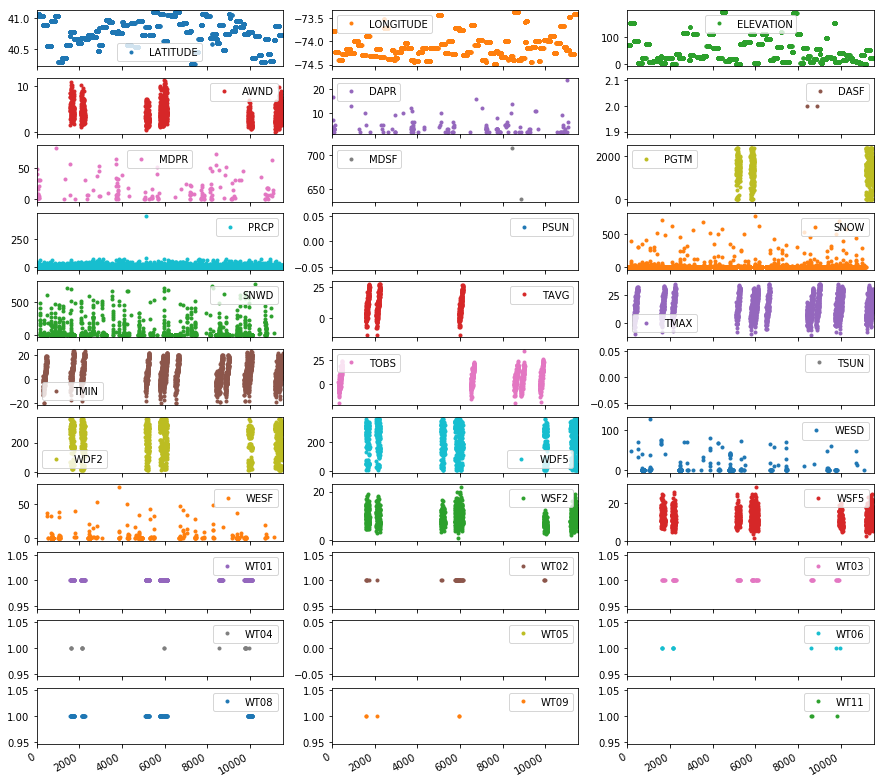

In [3]:
# Plot features
nyc_weather.plot(lw=0, marker='.', subplots=True, figsize=(15,15), layout=(-1,3))
plt.show()

## Empty columns

What I can see in the previous overall graph is that some of the colums are empty. Let's confirm this using the combination of *DataFrame.count()*, and *Series.sort_values()* method to get the number of null values present in each column.

> Note: The *count()* method returns the number of non-NaN values in each column

In [4]:
# Get number of non null values in each columns
nyc_weather.count().sort_values()

TSUN             0
WT05             0
PSUN             0
MDSF             2
DASF             2
WT11             3
WT09             5
             ...  
PRCP         11343
ELEVATION    11449
DATE         11544
LONGITUDE    11544
LATITUDE     11544
NAME         11544
STATION      11544
Length: 36, dtype: int64

That's it, three columns are empty, we can drop them as they won't give any informations to our models:
- PSUN - Daily percent of possible sunshine for the period
- TSUN - Total sunshine for the period
- WT05 - Hail (may include small hail)

In [5]:
# Drop empty columns
nyc_weather.drop(['PSUN', 'TSUN','WT05'], axis=1, inplace=True)

## Columns with very low data

I've found 2 columns wich the non-null values repesent the majority of the rows. This is very low and might not be usefull to train our model:
- DASF - Number of days included in the multiday snow fall total (MDSF) 
- MDSF - Multiday snowfall total 

Looking a bit more on the description of this column, I've found that those columns count the number of consecutive day of snow fall and the cumulated snow that falls during those cumulative days.

There's also two other fields that are similar to DASF and MDSF:
- DAPR - Number of days included in the multiday precipitation total (MDPR)
- MDPR - Multiday precipitation total (use with DAPR and DWPR, if available)

This columns are related to precipitation total for the multiday precipitaion total.

As I do really not see how this information could be used, I've decided to drop the four of them.


In [6]:
# Drop cumulative days column informations
nyc_weather.drop(['DASF', 'MDSF','DAPR', 'MDPR'], axis=1, inplace=True)

## Rows related the 1st of July 2016

Looking at the dates we have in this dataset, I've found that it covers the 1st of January 2016 to the 1st of July 2016.

The *travel* dataset, covers the same interval but the 1st of July 2016.

As I will never use *weather* information for days that are not in the *travel* dataset, I will simply drop lines where DATE='2016-07-01'

In [7]:
# Get max day from nyc_weather
print("Max date in dataset                   :", nyc_weather['DATE'].sort_values(ascending=False).iloc[0])

# Count lines related to DATE='2016-07-01'
lines_to_remove=len(nyc_weather[nyc_weather.DATE == '2016-07-01'].index)
print("Number of lines for DATE='2016-07-01' :", lines_to_remove)

# Count total lines
total_lines=len(nyc_weather.index)
print("Total number of lines in dataset      :", total_lines)

# Drop lines related to DATE='2016-07-01'
nyc_weather=nyc_weather[nyc_weather.DATE != '2016-07-01']
print("Number of lines after cleaning        :", len(nyc_weather.index))

if(total_lines == lines_to_remove + len(nyc_weather.index)):
    print("Removal OK")
else:
    print("Number of lines removed does not match total number of lines")


Max date in dataset                   : 2016-07-01
Number of lines for DATE='2016-07-01' : 57
Total number of lines in dataset      : 11544
Number of lines after cleaning        : 11487
Removal OK


# Categorical and Numerical columns

Using the *describe()* method on the dataset, I've been able to quickly identify *categorical* values, and by exclusion the *numerical* ones.
Of course, I do not consider *STATION*, *NAME*, *LATITUDE*, *LONGITUDE* AND *DATE* columns as they are identification keys of the lines.

> Note: I use the *astype()* method to get values as integers. This will be more easy to identify categorical values.

In [8]:
nyc_weather.describe().astype('int')

,LATITUDE,LONGITUDE,ELEVATION,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WDF2,WDF5,WESD,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11
count,11487,11487,11392,1445,725,11287,6951,3067,546,2410,2420,852,1448,1444,346,455,1448,1444,436,40,54,17,10,172,5,3
mean,40,-74,46,3,1306,2,4,26,10,14,4,6,208,206,7,2,8,11,1,1,1,1,1,1,1,1
std,0,0,44,1,555,8,37,90,8,9,8,8,98,102,18,8,3,3,0,0,0,0,0,0,0,0
min,40,-74,2,0,1,0,0,0,-13,-11,-19,-18,10,5,0,0,0,1,1,1,1,1,1,1,1,1
25%,40,-74,13,2,1037,0,0,0,4,6,-1,0,150,137,0,0,6,8,1,1,1,1,1,1,1,1
50%,40,-74,24,3,1354,0,0,0,10,14,5,7,220,210,0,0,8,11,1,1,1,1,1,1,1,1
75%,40,-74,72,5,1627,1,0,0,17,22,10,13,300,300,1,0,10,14,1,1,1,1,1,1,1,1
max,41,-73,188,11,2359,451,770,780,27,35,22,33,360,360,126,74,21,28,1,1,1,1,1,1,1,1


The *WT* columns seems to be categorical ones. Look at the *mean*, *std* and *max* values ;-)

There's also two interseting columns, *WDF2* and *WDF5* which, according to the dataset description, determines the direction of the wind. Those two columns should be defined as categorical one, classifying wind direction in distinct directions like North-East, South-West and so on.
We'll see below.


## The WT* columns

Let's explore first what I've identifed as *categorical* columns: The one starting with WT:

In [9]:
# Get WT column names
cat_columns=nyc_weather.filter(regex='WT').columns
nyc_weather[cat_columns].describe().astype('int')

,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11
count,436,40,54,17,10,172,5,3
mean,1,1,1,1,1,1,1,1
std,0,0,0,0,0,0,0,0
min,1,1,1,1,1,1,1,1
25%,1,1,1,1,1,1,1,1
50%,1,1,1,1,1,1,1,1
75%,1,1,1,1,1,1,1,1
max,1,1,1,1,1,1,1,1


As I've seen above, most of the lines into those columns are fill win *NaN* values. We can confirm that looking at the previous *describe()* graph. The min and max values for those column are equal to 1, with a standard deviation of 0. This means that we do have only 1 values in those columns, the rest is set to *NaN*.

In [10]:
for col in cat_columns:
    print("Unique values in {} column: {}".format(col, nyc_weather[col].unique()))

Unique values in WT01 column: [nan  1.]
Unique values in WT02 column: [nan  1.]
Unique values in WT03 column: [nan  1.]
Unique values in WT04 column: [nan  1.]
Unique values in WT06 column: [nan  1.]
Unique values in WT08 column: [nan  1.]
Unique values in WT09 column: [nan  1.]
Unique values in WT11 column: [nan  1.]


So what ? Well, easy, simply replace the *NaN* cells in those columns by a *0* and we are done, the *WT* columns will be categorical ones filles in with 0 and 1 values:

In [11]:
# fill NaN values in WT column with 0
df=nyc_weather.copy()
df[cat_columns]=df[cat_columns].fillna(0)
nyc_weather=df.copy()

Just to confirm, let display the unique values and *describe()* method.
Perfect :-)

In [12]:
for col in cat_columns:
    print("Unique values in {} column: {}".format(col, nyc_weather[col].unique()))

nyc_weather[cat_columns].describe().astype('int')

Unique values in WT01 column: [0. 1.]
Unique values in WT02 column: [0. 1.]
Unique values in WT03 column: [0. 1.]
Unique values in WT04 column: [0. 1.]
Unique values in WT06 column: [0. 1.]
Unique values in WT08 column: [0. 1.]
Unique values in WT09 column: [0. 1.]
Unique values in WT11 column: [0. 1.]


,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11
count,11487,11487,11487,11487,11487,11487,11487,11487
mean,0,0,0,0,0,0,0,0
std,0,0,0,0,0,0,0,0
min,0,0,0,0,0,0,0,0
25%,0,0,0,0,0,0,0,0
50%,0,0,0,0,0,0,0,0
75%,0,0,0,0,0,0,0,0
max,1,1,1,1,1,1,1,1


## The *WDF2* and *WDF5* columns

So, I've mention that those two columns do determine the direction of the wind measured by weather stations. The first one contains the wind direction during the last 2 mn, the second one for the last 5 minutes.

The direction is expressed in degrees, 360 meaning the North, 180 the South.

Let's first look at their characteristics, including informations on the three columns concerning wind speed:
- AWSD
- WSD2
- WSD5

As an evidence, I should consider values in wind direction columns only when there's wind, which means value in *AWND* is not equal to NaN.

Let's first display the weather station that measure the wind speed.

In [13]:
nyc_weather[~nyc_weather.AWND.isna()].groupby('STATION')[['AWND']].describe()

AWND                                                  
             count      mean       std  min    25%  50%    75%   max
STATION                                                             
USW00014732  182.0  4.903297  1.902249  1.6  3.425  4.6  5.775  10.8
USW00014734  182.0  4.304945  1.824368  1.1  3.000  4.1  5.200  10.2
USW00054743  182.0  2.476923  1.361838  0.1  1.500  2.2  3.075   6.8
USW00054787  180.0  4.236111  1.652111  1.0  3.100  3.9  5.125   9.8
USW00094728  177.0  2.655367  1.155661  0.6  1.900  2.5  3.300   7.0
USW00094741  179.0  3.346369  1.488580  0.5  2.300  3.0  4.300   7.2
USW00094745  181.0  3.616575  1.895360  1.1  2.300  3.1  4.500   9.9
USW00094789  182.0  5.296703  2.142413  1.6  3.700  5.0  6.500  11.2

It seems that only 9 of them do measure the wind speed.

Ok, let's have a look now at the wind direction columns.

In [14]:
wind_columns=['AWND', 'WSF2', 'WDF2', 'WDF5', 'WSF5']
nyc_weather[wind_columns].describe()

,AWND,WSF2,WDF2,WDF5,WSF5
count,1445.000000,1448.000000,1448.000000,1444.000000,1444.000000
mean,3.859377,8.771478,208.887431,206.159972,11.938989
std,1.949278,3.050781,98.654138,102.189245,3.984617
min,0.100000,0.900000,10.000000,5.000000,1.300000
25%,2.500000,6.700000,150.000000,137.500000,8.900000
50%,3.500000,8.100000,220.000000,210.000000,11.200000
75%,5.000000,10.700000,300.000000,300.000000,14.300000
max,11.200000,21.900000,360.000000,360.000000,28.600000


Around 10% of lines of the Dataset contains information in those columns.

Let's look at their correlation.

> Note: I do remove the lines where *WDF2* is NaN to not negatively influence the correlation matrix

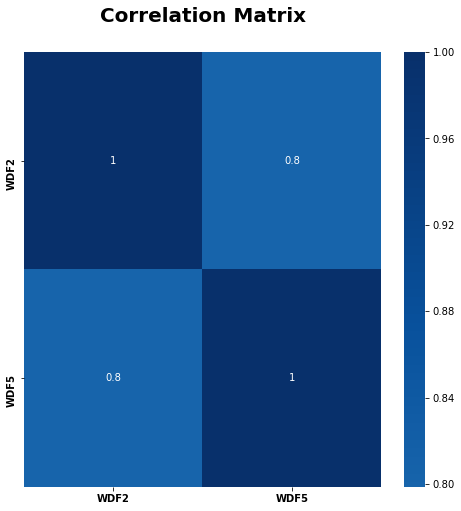

In [15]:
draw_correlation_matrix(nyc_weather[nyc_weather.WDF2.notna()][['WDF2', 'WDF5']], figsize=(8,8))

That's clear, those two columns have a correlation factor really high (near 1.0), which means that one of them should be dropped.

I've decided to drop the *WDF5* as it has a bit less of measures (1'452 against 1'456 for the *WDF2*)

Regarding *WDF2*, I will transform it into categorical columns by distributing values into a new feature, *WDIR*, using the following translation table:

> Note: The NaN values will be categorized has No-Wind values with direction code = 'O'

| Direction  | Direction Code | Low Angle limit | Higher Angle limit |
|:-----------|:--------------:|----------------:|-------------------:|
| North      | N              | 337.5           | 22.5               |
| North East | NE             | 22.5            | 67.5               |
| East       | E              | 67.5            | 112.5              |
| South East | SE             | 112.5           | 157.5              |
| South      | S              | 157.5           | 202.5              |
| South West | SW             | 202.5           | 247.5              |
| West       | W              | 247.5           | 292.5              |
| North West | NW             | 292.5           | 337.5              |
| No Wind    | O              | NaN             | NaN.               |

This new classification stored in the new *WDIR* column will be then converted into indicator variables using *pandas.get_dummies()*

> Note: Before doing this classification I will verify that each time I have a wind direction value, I also have a wind speed. Otherwise, the wind direction will be set to *No Wind*

In [16]:
# Drop *WDF5* column
nyc_weather=nyc_weather.drop(['WDF5'], axis=1)


In [17]:
def get_wind_direction(value) -> str:
    """
    Function that will convert a value in a direction code.
    
    Note that the value 'No direction' is based on a cell value = -1
    We will have to fill NaN values of dataset with -1 in order for this function to work.
    
    
    Results:
    --------
    str
    
    """
    if(value == -1):
        return 'O'
    elif(value <= 22.5):
        return 'N'
    elif(value <= 67.5):
        return 'NE'
    elif(value <= 112.5):
        return 'E'
    elif(value <= 157.5):
        return 'SE'
    elif(value <= 202.5):
        return 'S'
    elif(value <= 247.5):
        return 'SW'
    elif(value <= 292.5):
        return 'W'
    elif(value <= 337.5):
        return 'NW'
    else:
        return 'N'

# Ensure that if AWND column is NaN and WDF2 is not NaN, set WDF2 to -1 (if no wind, there's no direction)
for id in nyc_weather[np.logical_and(nyc_weather.AWND.isna(), ~nyc_weather.WDF2.isna())].index:
    nyc_weather.at[id, 'WDF2']=-1
    
# Apply conversion function to WDF2 columns (NaN replaced with -1)
nyc_weather['WDIR']=nyc_weather.fillna(-1)['WDF2'].apply(get_wind_direction)


print("Value counts of the new WDIR column:")
nyc_weather['WDIR'].value_counts()


Value counts of the new WDIR column:


O     10042
NW      298
S       289
W       239
N       140
SW      136
NE      135
SE      116
E        92
Name: WDIR, dtype: int64

Now, drop the *WDF2* column as it will be replaced by the categorical one *WDIR*, and run a *pandas.get_dummies()* function on the *WDIR* column.

In [18]:
# Drop WDF2 column
nyc_weather.drop('WDF2', axis=1, inplace=True)

In [19]:
# OneHotEncoder with pandas.get_dummies() method
nyc_weather = pd.get_dummies(nyc_weather, columns=['WDIR'])


The *pandas.get_dummies()* function added 9 columns as I did not set the *drop_first* parameter to *True*. Why ?

Well, I would like to be sure that the column that will be dropped is the *WDIR_O*, the one spcifying that there is no direction as there is no wind.

So the last thing I have to do now is to drop the *WDIR_O* columns as it represents lines where all other values are set to 0.

In [20]:
# Remove WDIR_O column
nyc_weather.drop('WDIR_O', axis=1, inplace=True)

In [21]:
# Let's display the WDIR_ columns whera AWND is not NaN
nyc_weather[nyc_weather.AWND.notna()][nyc_weather.filter(regex='WDIR_|AWND').columns].head(3)

,AWND,WDIR_E,WDIR_N,WDIR_NE,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SW,WDIR_W
1577,6.0,0,0,0,0,0,0,0,1
1578,5.6,0,0,0,0,0,0,0,1
1579,5.4,0,0,0,0,0,0,0,1


# Numerical columns

It's time now to have a look at the numerical columns. To get the list of these column names, I will simply remove from the dataset the categorical columns (*WT* and *WDIR*) and the static data columns (*NAME*, *STATION*, *LONGITUDE*, *LATITUDE* and *ELEVATION*)

> Note: *ELEVATION* is considered as static data information of the weather stations


In [22]:
# Build numercial column name list
num_columns=nyc_weather.filter(regex='^(?!WT)').filter(regex='^(?!WDIR)').drop(['NAME','STATION','LONGITUDE','LATITUDE','DATE', 'ELEVATION'], axis=1).columns

# Describe the columns
nyc_weather[num_columns].describe().astype('int')



,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WESD,WESF,WSF2,WSF5
count,1445,725,11287,6951,3067,546,2410,2420,852,346,455,1448,1444
mean,3,1306,2,4,26,10,14,4,6,7,2,8,11
std,1,555,8,37,90,8,9,8,8,18,8,3,3
min,0,1,0,0,0,-13,-11,-19,-18,0,0,0,1
25%,2,1037,0,0,0,4,6,-1,0,0,0,6,8
50%,3,1354,0,0,0,10,14,5,7,0,0,8,11
75%,5,1627,1,0,0,17,22,10,13,1,0,10,14
max,11,2359,451,770,780,27,35,22,33,126,74,21,28


As I can see, except for the PRCP column, most of them contains values for mostly less then 10% of the lines.

That should be normal. The *SNOW* column gives the quantity of snow fall during the day, it would have been surprising to have snow every day in NYC ;-)

Before doing a deep dive on each column, I will start analyzing any correlation between them.

## Correlation matrix

Let's use my Correlation Matrix Heatmap drawing function on all the features of the dataset.


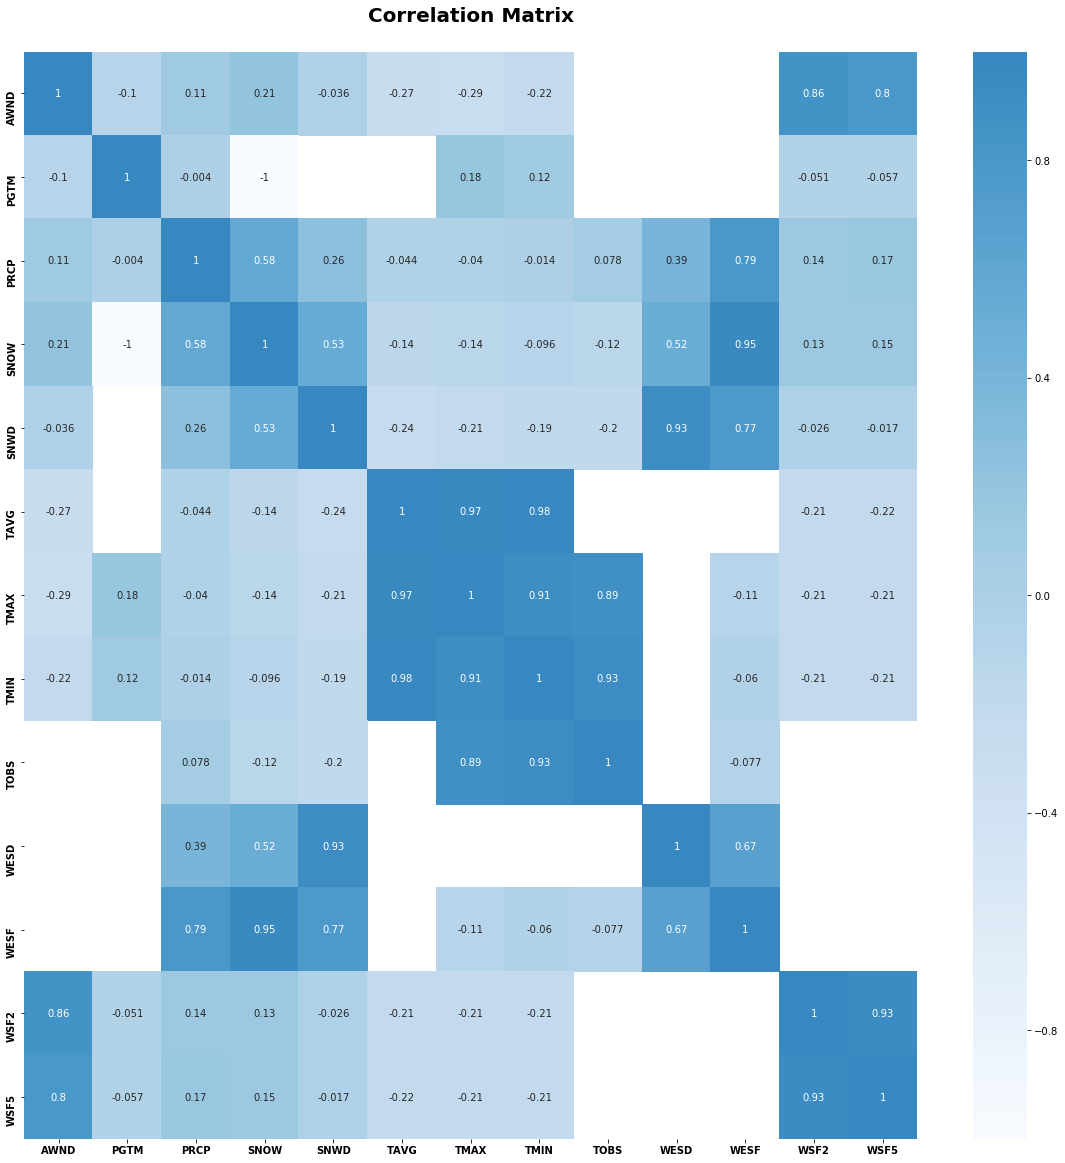

In [23]:
# let's graph a correlation matrix with a Seaborn graph
# Function comes from 'my_utils' library
draw_correlation_matrix(dataset=nyc_weather[num_columns], figsize=(20,20))


Nice result :-)

Zoom on some results from the previous graph and identify any features to drop.

## AWND, WSF2 and WSF5 columns

Those columns are highly correlated, they report respectively the Average Wind Speed (AWND), the fastest 2-minutes Wind Speed (WSF2) and the fastest 5-minutes Wind Wpeed (WSF5).

> Note: I've excluded all the values where *AWND* is NaN to not influence negatively the correlation matrix. 

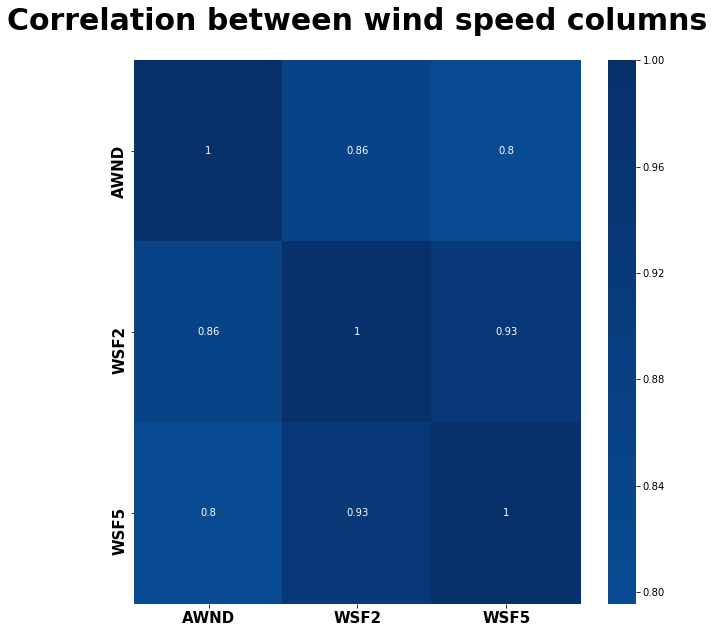

In [24]:
# Correlation between wind speed columns
draw_correlation_matrix(nyc_weather[['AWND', 'WSF2', 'WSF5']],
                        title="Correlation between wind speed columns",
                        fontsize=15, center=0)

I decide to drop the *WSF2* and *WSF5* columns, and replace all the NaN values in the *AWND* columns with 0

> Note: Previously, while building the *WDIR* categorical columns, I've checked that each time I had a wind direction (*WDIR_O == 1), the AWND column as a value > 0. This is another good reason to keep that column and drop the others.

In [25]:
# Drop WSF2 and WSF5 columns
nyc_weather.drop(['WSF2', 'WSF5'], axis=1, inplace=True)

In [26]:
# Replace NaN value in AWND column with 0
nyc_weather['AWND'].fillna(0, inplace=True)

print("Number of NaN values in AWND column:",nyc_weather['AWND'].isna().sum())

Number of NaN values in AWND column: 0


## PGTM column

There's another column that describes feature about wind: *PGTM*

This feature describe the number of seconds the weather station observed a peak gust.

Instead of keeping this column as is, I will transform it using *pandas.get_dummies()* method to build a categorical column: PEAK = yes or no

In [27]:
def get_peak_gust_status(value) -> str:
    """
    Function that will convert the peak gust time in Y if > 0, N otherwise.
    
    Do not forget to fill NaN values with 0 before applying this function
    
    Results:
    --------
    str
    
    """
    if(value > 0):
        return 'Y'
    else:
        return 'N'

# Apply conversion function to PGTM columns and store result in PEAK column
nyc_weather['PEAK']=nyc_weather.fillna(0)['PGTM'].apply(get_peak_gust_status)


print("Value counts of the new PEAK column:")
nyc_weather['PEAK'].value_counts()

Value counts of the new PEAK column:


N    10762
Y      725
Name: PEAK, dtype: int64

ok, now convert the *PEAK* columns in categorical one using *pandas.get_dummies()* and drop the useless *PGTM* column.

In [28]:
nyc_weather.drop('PGTM', axis=1, inplace=True)

In [29]:
# OneHotEncoder with pandas.get_dummies() method
nyc_weather = pd.get_dummies(nyc_weather, columns=['PEAK'], drop_first=True)

## *TAVG*, *TMAX* and *TMIN* columns

Those columns also are highly correlated, they concern the temperature mesured:
- TAVG - Average Temperature.
- TMAX - Maximum temperature
- TMIN - Minimum temperature


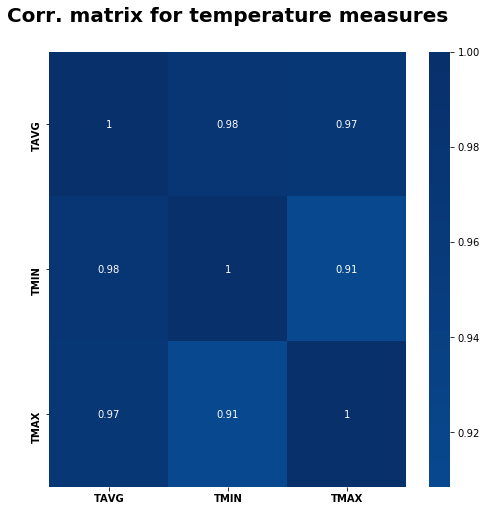

In [30]:
draw_correlation_matrix(nyc_weather[['TAVG', 'TMIN', 'TMAX']],
                        title="Corr. matrix for temperature measures",
                        figsize=(8,8))

Having a closer look at those specific columns, I found that we only have three weather stations that do report values for *TAVG*, while *TMAX* and *TMIN* are reported on more weather station (14 stations).

Furthermore, each weather stations with a *TMIN* value **do have** a *TMAX* value.

In [31]:
# Filter lines where TMiN.notna() and count values
nyc_weather[nyc_weather.TMIN.notna()][['STATION', 'TMAX', 'TMIN', 'TAVG']].groupby(by='STATION').count().sort_values(by='TAVG', ascending=False)

,TMAX,TMIN,TAVG
STATION,,,
USW00014732,182,182,182
USW00014734,182,182,182
USW00094789,182,182,182
USC00066655,172,182,0
USC00280907,180,180,0
USC00281335,182,182,0
USC00282023,60,60,0
USC00283704,182,182,0
USC00301309,182,182,0


For that reason, I've decided to replace the *TAVG* columns with an average based on the TMIN and TMAX values.

I'm not sure this is completly right, but this will solve the correlation between *TMIN* and *TMAX*, as well as increase the number af *TAVG* values.

While doing this transformation, I'll aslo create a new column, *TSTD*, which will contains the absolute value of *TMAX* minus *TAVG*. That way, I will keep the information of the variation amplitude of the temperature for each measures. A sort of standard deviation with the mean of two values ;-)

> Note 1: *TAVG* values where *TMIN* and *TMAX* are equal to NaN will be filled with NaN value, same for the *TSTD* feature.

> Note 2: As I've confirmed that each time I have a value for *TMIN*, I have one for *TMAX*, filtering will be done on *TMIN* only


In [32]:
# get average function
def get_average(tmin, tmax) -> float:
    """
    Returns the average of the the two values passed as parameter.
    This function takes care of parameters received equal to np.nan
    
    Returns:
    --------
    float
    
    """
    # initialize returned variable
    tavg=np.nan
    
    # Try to calculate the average
    try:
        tavg=(tmin+tmax)/2
    # if not posible, set return value to np.nan
    except:
        tavg=np.nan
        
    # Return calculated value
    return tavg
        
def get_diff(tmax, tavg) -> float:
    """
    Returns the absolute difference the two values passed as parameter.
    This function takes care of parameters received equal to np.nan
    
    Returns:
    --------
    float
    
    """

    # initialize returned variable
    tstd=np.nan

    # Try to calculate the difference
    try:
        tstd=tmax-tavg

    # if not posible, set return value to np.nan
    except:
        tstd=np.nan
        
    # return calculated value
    return tstd

# Set TAVG to NaN where TMIN.isna()
nyc_weather['TAVG']=nyc_weather.apply(lambda x: get_average(x['TMIN'], x['TMAX']), axis=1)

# Set TAVG to NaN where TMIN.isna()
nyc_weather['TSTD']=nyc_weather.apply(lambda x: get_diff(x['TMAX'], x['TAVG']), axis=1)


# Display some results
nyc_weather[nyc_weather.TMAX.notna()][['STATION', 'TMAX', 'TMIN', 'TAVG', 'TSTD']].head(2)
#nyc_weather.loc[0:0]['TMIN']

,STATION,TMAX,TMIN,TAVG,TSTD
305,USC00280907,8.3,2.8,5.55,2.75
306,USC00280907,3.3,-0.6,1.35,1.95


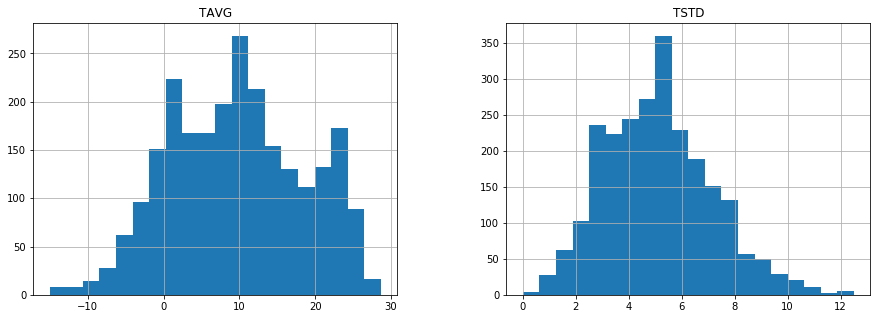

In [33]:
# Display histogram of TAVG values
nyc_weather[['TAVG', 'TSTD']].hist(bins=20, figsize=(15,5))
plt.show()

In [34]:
# Display the number of empty values in TAVG (the one equal to -99)
nyc_weather[['TAVG', 'TSTD']].isna().sum()


TAVG    9077
TSTD    9077
dtype: int64

The *TAVG* column has been recalculated using *TMIN* and *TMAX* average to fill some missing values, but there is still *TAVG* values that are set to *NaN*.

The reason is some temperature measures in the dataset are missing from weather station for each days reported.

Luckily, as we can see below, we have *at least* one weather station that reported an average temperature for each days of the dataset. What I will do is calculate using extrapolation the *TAVG* values that are missing for some stations, using the value of the nearest one for the same day. I'll do this in the next notebook: [NYC Taxi Travel Dataset Feature Engineering](./14.NYC%20Taxi%20Travel%20Dataset%20Feature%20Engineering.ipynb)

In [35]:
# Display the days of the dataset with the lowest number of weather station having an average temperature measure
# If the first value of the first days is > 0 => we have measures for all the days
nyc_weather[['DATE','TAVG']].groupby('DATE').count().sort_values('TAVG', ascending=True).head(3) #['TAVG'].isnull().value_counts()

,TAVG
DATE,
2016-06-30,12
2016-05-05,12
2016-05-20,12


About temperature, there's a final *TOBS* column wich contains the temperature at the time of observation. The number of values in this column is very low (857 entries), I'd prefer to drop this column, along with *TMIN* and *TMAX* now that they are useless.

In [36]:
nyc_weather.drop(['TOBS', 'TMIN', 'TMAX'], axis=1, inplace=True)

## SNOW, SNWD, WESD and WESF columns

4 columns in the dataset concern the snow:

- SNOW - Snowfall
- SNWD - Snow depth
- WESD - Water equivalent of snow on the ground
- WESF - Water equivalent of snowfall

Let's display again the correlation matrix between those columns:


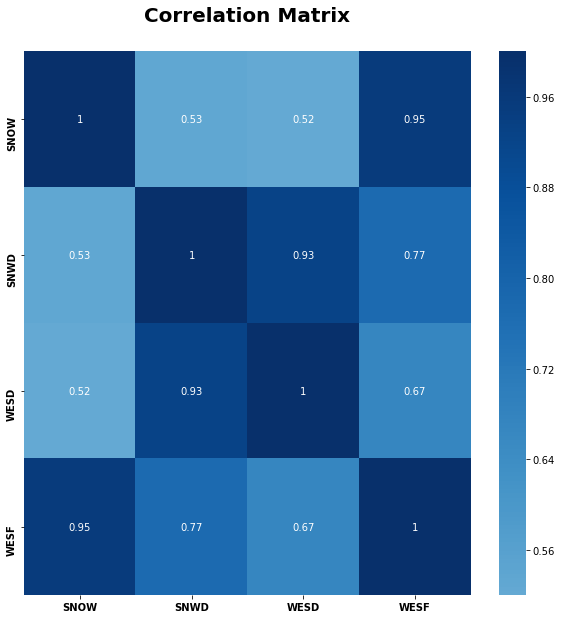

In [37]:
# Build numercial column name list
snow_columns=['SNOW', 'SNWD', 'WESD', 'WESF']

# Draw correlation matrix
draw_correlation_matrix(nyc_weather[snow_columns])


Not surprisingly, there is a strong correlation between *WESD* (Water Equivalent of Snow on the ground) and *SNWD* (Snow Depth on the road), as well as between *SNOW* (Total snowfall) and *WESF* (Water Equivalent of Snow Fall).

Furthermore, if I check the NaN values in those four columns, I would find that *SNOW* and *SNWD* contains a lot more of information than *WESF* and *WESD*.


In [38]:
nyc_weather[snow_columns].describe()

,SNOW,SNWD,WESD,WESF
count,6951.000000,3067.000000,346.000000,455.000000
mean,4.576320,26.544180,7.737283,2.833626
std,37.602428,90.830324,18.801285,8.704819
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.500000,0.800000
max,770.000000,780.000000,126.700000,74.900000


For that reason, I would prefer to ignore *WESD* and *WESF* columns and drop them from my dataset


In [39]:
# Remove WESD and WESF columns
nyc_weather.drop(['WESD', 'WESF'], axis=1, inplace=True)


Ok, now I will use the *SNOW* and *SNWD* columns to build two new categorical features:

- SNOW_FALL:

Values will be set to 1 if *SNOW* is not NaN or > 0

This will indicate if the day is a snowing day.

- SNOW_ROAD:

Values will be 1 if *SNWD* is not NaN or > 0

This will indicate if there is snow on the road


In [40]:
def check_na_or_null(value) -> int:
    """
    Check if value passed as parameter is greater than 0
    
    return 1 if True, 0 otherwise
    
    
    Returns:
    --------
    int
    
    """
    if value > 0:
        return 1
    return 0

# apply check_na_or_null function on SNOW to create new SNOW_FALL categorical feature
nyc_weather['SNOW_FALL']=nyc_weather['SNOW'].fillna(0).apply(check_na_or_null)

# apply check_na_or_null function on SNWD to create new SNOW_ROAD categorical feature
nyc_weather['SNOW_ROAD']=nyc_weather['SNWD'].fillna(0).apply(check_na_or_null)



## PRCP column

And finally, the PRCP feature. This one contains the quantity of precipitation that falls on the weather station that made the measure.

Plotting the values will show up that there is a value that must be considered as an outlier, more than that a mistake in the mesure done (more that 4 meters of precipitation detected in a day by one of the weather station, that sounds wrong.

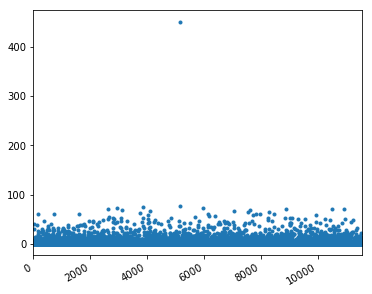

In [41]:
# Plot PRCP features
nyc_weather['PRCP'].plot(lw=0, marker='.', subplots=True, figsize=(20,5), layout=(-1,3))
plt.show()


Let's have a look at this upper point.

In [42]:
# Get line where PRCP > 400
nyc_weather[nyc_weather.PRCP > 400]

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11,WDIR_E,WDIR_N,WDIR_NE,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SW,WDIR_W,PEAK_Y,TSTD,SNOW_FALL,SNOW_ROAD
5148,USW00094741,"TETERBORO AIRPORT, NJ US",40.85,-74.06139,2.7,2016-02-14,5.6,451.1,NaN,NaN,-13.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,1,5.0,0,0


Ok, as I can see, we have one weather station concerned by this erroneous value, on *DATE = 2016-02-14* 

Looking at the other weather stations for the same day, I found that the *PRCP* value is equal to 0.

Best thing to do here is to replace this 451.1 mm of precipitation on day 2019-02-14 by 0 mm:

In [43]:
# Get PRCP measures for the '2016-02-14', groupe by DATE and sum the PRCP values
nyc_weather[nyc_weather.DATE == '2016-02-14'][['DATE', 'PRCP']].groupby('DATE').sum()



,PRCP
DATE,
2016-02-14,451.1


In [44]:
# sum of PRCP values equal the value of 451.1 => all other weather stations reported 0
# replace 451.1 value by 0
# row index is avalilable a few cell up ;-)
nyc_weather.at[5148, 'PRCP']=0

Plotting again the *PRCP* features shows a more normal situation.

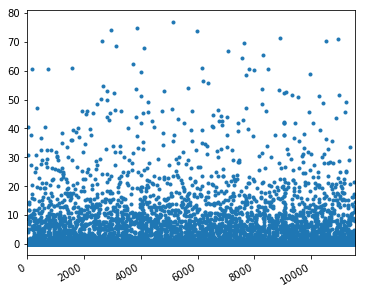

In [45]:
# Plot PRCP features
nyc_weather['PRCP'].plot(lw=0, marker='.', subplots=True, figsize=(20,5), layout=(-1,3))
plt.show()


# Save resulting datasets to SQL Database

Ok, all done for this first data cleaning process. As explained in the [Data Preparation Introduction](10.Data%20Preparation%20Introduction.ipynb) notebook, I will build two dataset from the one cleaned previously and store them into our database: *Weather Categorical* and *Weather Numerical*



## Weather Categorical Dataset

This dataset will contains all the *categorical* columns, which are:

- WT_*
- WDIR_*
- PEAK_Y
- SNOW_FALL
- SNOW_ROAD

After creating a filter based on regex and named column, I will save them into the SQL Database.

> Note 1: I will drop the weather station static data (*NAME*, *LATITUDE*, *LONGITUDE*, *ELEVATION*) except the *STATION* id, as I do not want to save those values in the two datasets (they've already been included in *stations* dataset in the [The 83 Weather Stations notebook](12.The%2083%20Weather%20Stations.ipynb)).

> Note 2: The *WT* features are encoded as *float64*, which is not right. I will re-encode them as *int64*

In [46]:
# WT* categorical column encoded as float64, recode them as int
nyc_weather = nyc_weather.astype({
    "WT01": int,
    "WT02": int,
    "WT03": int,
    "WT04": int,
    "WT06": int,
    "WT08": int,
    "WT09": int,
    "WT11": int
})

# Check WT columns except STATION and DATE are int64 dtype
nyc_weather.filter(regex='WT').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11487 entries, 0 to 11542
Data columns (total 8 columns):
WT01    11487 non-null int64
WT02    11487 non-null int64
WT03    11487 non-null int64
WT04    11487 non-null int64
WT06    11487 non-null int64
WT08    11487 non-null int64
WT09    11487 non-null int64
WT11    11487 non-null int64
dtypes: int64(8)
memory usage: 807.7 KB


In [47]:
# Create categorical filter
cat_columns=list(nyc_weather.filter(regex='WT.*|WDIR.*|PEAK_Y|SNOW_.*').columns)

# Save to SQL Database
save_sql(nyc_weather[['STATION', 'DATE'] + cat_columns], tablename='weather_cat')

Saving OK


True

In [48]:
# Check what has been stored into database
load_sql('weather_cat').head(2)

Query: SELECT * FROM weather_cat


,STATION,DATE,WT01,WT02,WT03,WT04,WT06,WT08,WT09,WT11,WDIR_E,WDIR_N,WDIR_NE,WDIR_NW,WDIR_S,WDIR_SE,WDIR_SW,WDIR_W,PEAK_Y,SNOW_FALL,SNOW_ROAD
0,US1NYWC0003,2016-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,US1NYWC0003,2016-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ok, good, here we are with a second dataset of categorical values coming from the NYC Weather Stations Dataset :-)

## Weather Numerical Dataset

This dataset will contains all the *numerical* columns, which are all the column except the weather station static and categorical columns.

To get them, I'll use the *.loc[]* method using an exclusion approach (inspired by code found on this web document: [https://www.statology.org/pandas-exclude-column/](https://www.statology.org/pandas-exclude-column/)).

> Note: I'll keep the *STATION* id and the *DATE* feature in this dataset.

In [49]:
# Save numerical features dataset into SQL Database
save_sql(nyc_weather.loc[:, ~nyc_weather.columns.isin(cat_columns)].drop(['NAME','LATITUDE','LONGITUDE','ELEVATION'], axis=1), tablename='weather_num')

Saving OK


True

In [50]:
# Check what has been stored into database
load_sql('weather_num').head(2)

Query: SELECT * FROM weather_num


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TSTD
0,US1NYWC0003,2016-01-01,0.0,0.0,0.0,NaN,NaN,NaN
1,US1NYWC0003,2016-01-02,0.0,0.0,0.0,NaN,NaN,NaN


# Well done !!

Here I am :-)

As expected, the data cleaning process for this NYC Weather Stations dataset is far more complex than the NYC Taxi Travel one.

It's time now to make some *Advanced Feature Engineering* on the 4 new datasets we've created:
- travel
- stations
- weather_cat
- weather_num

Let's continue with the next notebook: [NYC Taxi Travel Dataset Feature Engineering](14.NYC%20Taxi%20Travel%20Dataset%20Feature%20Engineering.ipynb)
